In [70]:
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys
from append_directories import *
data_generation_folder = (append_directory(3) + "/generate_data")
sys.path.append(data_generation_folder)
import generate_true_unconditional_samples

In [71]:
#index is assumed to be in i*n+j form where (i,j) is index of matrix
def index_to_spatial_location(minX, maxX, minY, maxY, n, index):

    # create one-dimensional arrays for x and y
    x = np.linspace(minX, maxX, n)
    y = np.linspace(minY, maxY, n)
    # create the mesh based on these arrays
    X, Y = np.meshgrid(x, y)
    X = X.reshape((np.prod(X.shape),1))
    Y = Y.reshape((np.prod(Y.shape),1))
    
    xlocation = (X[index])[0]
    ylocation = (Y[index])[0]
    return (xlocation, ylocation)

def matrix_index_to_index(matrix_index, n):

    return (matrix_index[0]*n+matrix_index[1])


def index_to_matrix_index(index, n):

    return (int(index % n), int(index / n))

def visualize_spatial_field(observation, min_value, max_value, figname):

    fig, ax = plt.subplots(1)
    plt.imshow(observation, vmin = min_value, vmax = max_value)
    plt.savefig(figname)

def log_transformation(images):

    images = np.log(np.where(images !=0, images, np.min(images[images != 0])))

    return images


def produce_true_and_generated_marginal_density(minX, maxX, minY, maxY, n,
                                                number_of_replicates, missing_index,
                                                unconditional_generated_samples, uncond_brv,
                                                figname):
    
    #log transformation
    uncond_brv = log_transformation(uncond_brv)
    #conditional_vectors is shape (number of replicates, m)
    marginal_density = (uncond_brv[:,missing_index]).reshape((number_of_replicates,1))
    matrix_index = index_to_matrix_index(missing_index, n)
    generated_marginal_density = unconditional_generated_samples[:,0,int(matrix_index[0]),int(matrix_index[1])]
    uncond_brm = uncond_brv.reshape((number_of_replicates, 1, n, n))

    fig, axs = plt.subplots(ncols = 2, figsize = (10,5))
    pdd = pd.DataFrame(marginal_density,
                                    columns = ["true"])
    generated_pdd = pd.DataFrame(generated_marginal_density,
                                    columns = ["generated"])

    axs[0].imshow(uncond_brm[0,:,:,:].reshape((n,n)), vmin = np.quantile(uncond_brm[0,:,:,:], [.01])[0],
                 vmax = np.quantile(uncond_brm[0,:,:,:], [.99])[0])
    #using scott's method to compute bandwidth which depends on number of data points and dimension of data so as long as
    #bw_adjust is the same between true and generated and true and generated have same number of data points
    #and the same across pixels
    axs[0].plot(matrix_index[0], matrix_index[1], "r+")
    sns.kdeplot(pdd, bw_method = "scott", bw_adjust = 1, palette = ["blue"], ax = axs[1])
    sns.kdeplot(data = generated_pdd["generated"], palette = ["orange"], bw_adjust = 1, ax = axs[1])
    axs[1].set_title("Marginal")
    axs[1].set_xlim(-4,10)
    axs[1].set_ylim(0,.5)
    location = index_to_spatial_location(minX, maxX, minY, maxY, n, missing_index)
    rlocation = (round(location[0],2), round(location[1],2))
    axs[1].set_xlabel("location: " + str(rlocation))
    axs[1].legend(labels = ['true', 'generated'])
    plt.savefig(figname)
    plt.clf()

def produce_true_and_generated_bivariate_density(minX, maxX, minY, maxY, n,
                                                 number_of_replicates, missing_two_indices,
                                                 unconditional_generated_samples, uncond_brv,
                                                 figname):
    
    #log transformation
    uncond_brv = log_transformation(uncond_brv)
    #conditional_vectors is shape (number of replicates, m)
    uncond_brm = uncond_brv.reshape((number_of_replicates, 1, n, n))
    bivariate_density = (uncond_brv[:,missing_two_indices]).reshape((number_of_replicates,2))
    matrix_index1 = index_to_matrix_index(missing_indices[0], n)
    matrix_index2 = index_to_matrix_index(missing_indices[1], n)
    generated_bivariate_density = np.concatenate([(unconditional_generated_samples[:,0,int(matrix_index1[0]),int(matrix_index1[1])]).reshape((number_of_replicates,1)),
                                                   (unconditional_generated_samples[:,0,int(matrix_index2[0]),int(matrix_index2[1])]).reshape((number_of_replicates,1))],
                                                   axis = 1)
    bivariate_density = np.concatenate([bivariate_density, generated_bivariate_density], axis = 0)
    print(bivariate_density)
    class_vector = np.concatenate([(np.repeat('true', number_of_replicates)).reshape((number_of_replicates,1)),
                                   (np.repeat('generated', number_of_replicates)).reshape((number_of_replicates,1))], axis = 0)
    bivariate_density = np.concatenate([bivariate_density, class_vector], axis = 1)
    fig, axs = plt.subplots(ncols = 2, figsize = (10,5))
    #emp_mean = round(np.mean(marg), 2)
    #emp_var = round(np.std(marginal_density)**2, 2)
    pdd = pd.DataFrame(bivariate_density, columns = ['x', 'y', 'class'])
    pdd = pdd.astype({'x': 'float64', 'y': 'float64'})
    #partially_observed_field = np.multiply(mask.astype(bool), observed_vector.reshape((n,n)))
    axs[0].imshow(uncond_brm[0,:,:,:].reshape((n,n)),vmin = -1, vmax = 4)
    axs[0].plot(matrix_index1[0], matrix_index1[1], "r+")
    axs[0].plot(matrix_index2[0], matrix_index2[1], "r+")
    print(bivariate_density)
    kde1 = sns.kdeplot(data = pdd, x = 'x', y = 'y', bw_method = "scott", bw_adjust = 1,
                ax = axs[1], hue = 'class', shade = True, levels = 5, alpha = .5)
    plt.xlim(-4,10)
    plt.ylim(-4,10)
    axs[1].set_title("Bivariate")
    location1 = index_to_spatial_location(minX, maxX, minY, maxY, n, missing_indices[0])
    rlocation1 = (round(location1[0],2), round(location1[1],2))
    location2 = index_to_spatial_location(minX, maxX, minY, maxY, n, missing_indices[1])
    rlocation2 = (round(location2[0],2), round(location2[1],2))
    axs[1].set_xlabel("location: " + str(rlocation1))
    axs[1].set_ylabel("location: " + str(rlocation2))
    plt.savefig(figname)
    plt.clf()

In [72]:
minX = -10
maxX = 10
minY = -10
maxY = 10
n = 32
range_value = 1.6
smooth_value = 1.6
number_of_replicates = 2250
missing_index = 700
missing_indices = [100,101]
home_folder = append_directory(3)
sys.path.append((home_folder + "/generate_data"))
import generate_true_unconditional_samples
uncond_samples = np.load((home_folder + "/generate_data/data/unconditional/diffusion/model3_beta_min_max_01_20_random0_2250.npy"))
#uncond_brv = (np.load((home_folder + "/generate_data/data/unconditional/true/unconditional_model3_range_1.6_smooth_1.6_2250.npy")))
seed_value = 3242
uncond_brv = generate_true_unconditional_samples.generate_brown_resnick_process(range_value, smooth_value,
                                                                   seed_value, number_of_replicates, n)

In [73]:
def produce_true_marginal_density(minX, maxX, minY, maxY, n,
                                 number_of_replicates, missing_index,
                                 uncond_brv):
    
    #log transformation
    uncond_brv = log_transformation(uncond_brv)
    #conditional_vectors is shape (number of replicates, m)
    marginal_density = (uncond_brv[:,missing_index]).reshape((number_of_replicates,1))
    matrix_index = index_to_matrix_index(missing_index, n)
    uncond_brm = uncond_brv.reshape((number_of_replicates, 1, n, n))
    print(marginal_density.shape)
    print(np.sum(marginal_density<-2.7))

    fig, axs = plt.subplots(ncols = 2, figsize = (10,5))
    pdd = pd.DataFrame(marginal_density,
                                    columns = ["true"])

    axs[0].imshow(uncond_brm[0,:,:,:].reshape((n,n)), vmin = np.quantile(uncond_brm[0,:,:,:], [.01])[0],
                 vmax = np.quantile(uncond_brm[0,:,:,:], [.99])[0])
    #using scott's method to compute bandwidth which depends on number of data points and dimension of data so as long as
    #bw_adjust is the same between true and generated and true and generated have same number of data points
    #and the same across pixels
    axs[0].plot(matrix_index[0], matrix_index[1], "r+")
    sns.kdeplot(pdd, bw_method = "scott", bw_adjust = 1, palette = ["blue"], ax = axs[1])
    axs[1].set_title("Marginal")
    axs[1].set_xlim(-4,10)
    axs[1].set_ylim(0,.5)
    location = index_to_spatial_location(minX, maxX, minY, maxY, n, missing_index)
    rlocation = (round(location[0],2), round(location[1],2))
    axs[1].set_xlabel("location: " + str(rlocation))
    axs[1].legend(labels = ['true', 'generated'])
    #plt.savefig(figname)
    #plt.clf()
    plt.show()

In [58]:
uncond_brv.shape

(2250, 961)

In [64]:
np.sum((log_transformation(uncond_brv[:,412])) < -2)

0

In [76]:
indices = np.array([i for i in range(0,200)])

In [77]:
indices[uncond_brv[:,4] < .06]

array([], dtype=int64)

(200, 1)
0


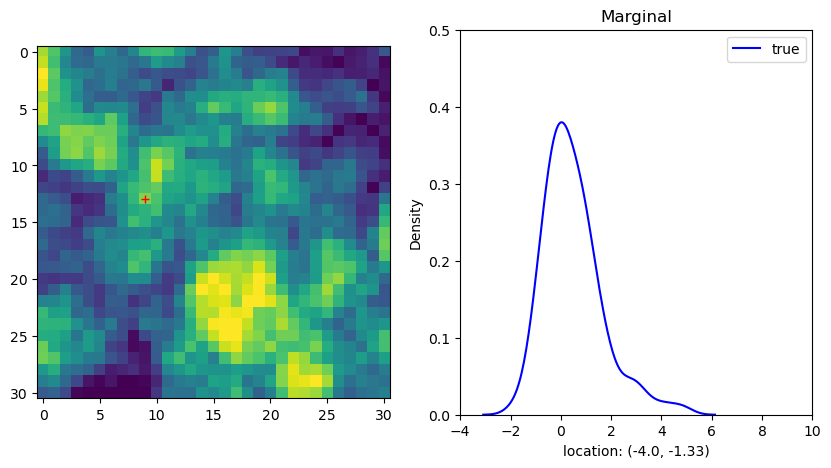

In [78]:
minX = -10
maxX = 10
minY = -10
maxY = 10
n = 31
number_of_replicates = 200
missing_index = 412

produce_true_marginal_density(minX, maxX, minY, maxY, n,
                                 number_of_replicates, missing_index,
                                 uncond_brv)